In [1]:
import sys

sys.path.append("../")

from depo.functions import Functions as func

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dttt1\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# -------------------------- LIBRARIES NECESSARY IN THIS PROJECT  -------------------------- #
import warnings
warnings.filterwarnings("ignore")

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
import xgboost as xgb

import pandas as pd

# DataSet extraction and global features declaration

In [3]:
# -------------------------- PATH OF THE DATASETS USED IN THE PROJECT  -------------------------- #

# Defines the Date format
dateFormat='%Y-%m-%d'

# -------------------------- PATH OF THE DATASETS USED IN THE PROJECT  -------------------------- #
df_retails = func.open_file('dataSets.zip/online_retail_II.csv')

# Data normalization

In [4]:
df_retails.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB


In [5]:
df_retails.rename(columns={'Invoice':'InvoiceNo', 'Customer ID':'CustomerID', 'Price':'UnitPrice'}, inplace=True)

# Checks the percentage of NaN values in the dataSet
df_retails.print_nan_columns()

,Missing Values,% Missing Values,Zero Values,% Missing Values,Zero Missing Values,% Zero Missing Values,Data Type
CustomerID,243007,22.770000,0,0.000000,243007,22.770000,float64
Description,4382,0.410000,0,0.000000,4382,0.410000,object
InvoiceNo,0,0.000000,0,0.000000,0,0.000000,object
StockCode,0,0.000000,0,0.000000,0,0.000000,object
Quantity,0,0.000000,0,0.000000,0,0.000000,int64
InvoiceDate,0,0.000000,0,0.000000,0,0.000000,object
UnitPrice,0,0.000000,6202,0.580000,6202,0.580000,float64
Country,0,0.000000,0,0.000000,0,0.000000,object
Total,247389,23.177414,6202,0.581054,253591,23.758468,-


<AxesSubplot:>

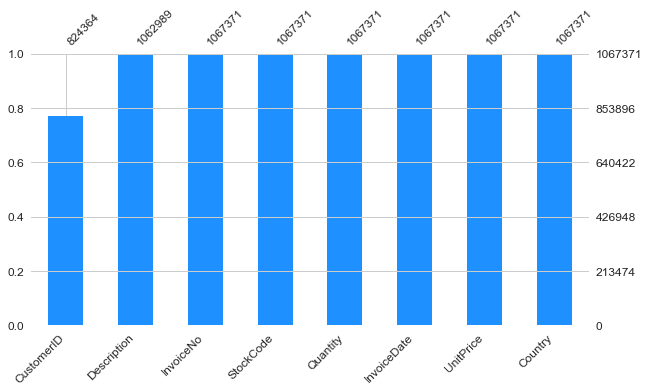

In [6]:
df_retails.print_nan_bar_chart()

<AxesSubplot:>

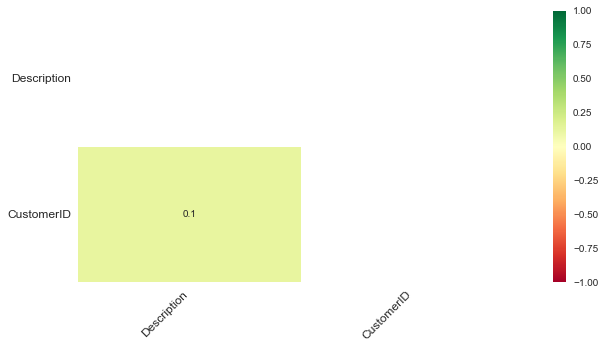

In [7]:
# Checks the relationship of the NaN columns
df_retails.print_nan_heat_map()

<AxesSubplot:>

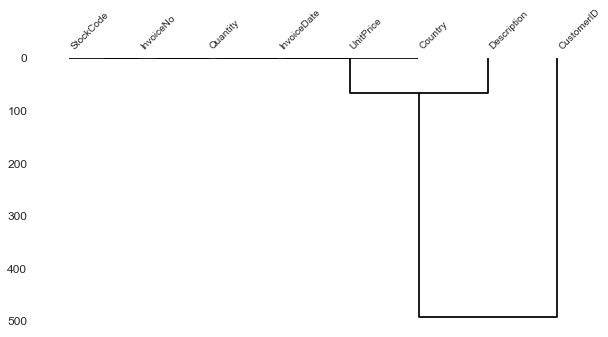

In [8]:
# Checks the relationship of the NaN columns
df_retails.print_nan_dendrogram()

### The graph Dendrogram shows a relationship from UnitPrice and Country when Description is NaN, so let's plot a Matrix graph to have an overview of these data.

<AxesSubplot:>

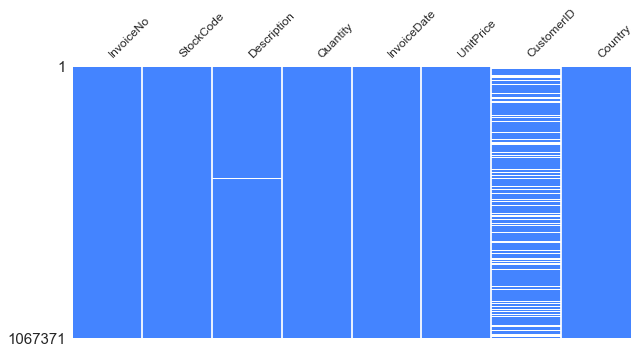

In [9]:
# Plots a matrix graph to have an overview of the dataSet
df_retails.print_nan_matrix()

### As shown though the Matrix above, UnitPrice and Country are not NaN Columns, so their influences in Description is not because they might be NaN

In [10]:
# Prints the data with Description null
df_temp = df_retails.copy()
df_where = df_temp[{"InvoiceNo", "UnitPrice", "Country"}].loc[df_temp["Description"].isnull()]
df_where.drop_duplicates(subset = ["UnitPrice", "Country"])

,Country,UnitPrice,InvoiceNo
470,United Kingdom,0.0,489521


In [11]:
# The Description Nan are from the same invoice, which has an UnitPrice 0, which should be ok to delete
# Nan Descriptions
df_retails.dropna(subset = ["Description"], inplace=True)

In [12]:
# Prints the data with CustomerID null
df_temp = df_retails.copy()
df_where = df_temp[{"StockCode", "InvoiceNo", "Description"}].loc[df_temp["CustomerID"].isnull()]
df_where.drop_duplicates(subset = ["StockCode", "InvoiceNo", "Description"])

,InvoiceNo,Description,StockCode
263,489464,85123a mixed,21733
283,489463,short,71477
284,489467,21733 mixed,85123A
577,489525,BLUE PULL BACK RACING CAR,85226C
578,489525,SET/6 3D KIT CARDS FOR KIDS,85227
...,...,...,...
1066997,581498,JUMBO BAG RED RETROSPOT,85099B
1066998,581498,JUMBO BAG BAROQUE BLACK WHITE,85099C
1066999,581498,LADIES & GENTLEMEN METAL SIGN,85150
1067000,581498,S/4 CACTI CANDLES,85174


In [13]:
# An analyse in the dataSet given doest show much the reason of CustomerID be NaN, so these data are deleted
#  To dont have impact in the results
df_retails.dropna(subset = ["CustomerID"], inplace=True)

# Converts Column InvoiceDate to DateTime
#df_retails['InvoiceDate'] = f.f_FormatToDate(df_retails['InvoiceDate'], dateFormat)

df_retails['InvoiceDate'] = pd.to_datetime(df_retails.InvoiceDate)

df_retails.InvoiceDate.describe()

count                  824364
unique                  41439
top       2011-11-14 15:27:00
freq                      543
first     2009-12-01 07:45:00
last      2011-12-09 12:50:00
Name: InvoiceDate, dtype: object

In [14]:
# Calculates a column Revenue, which is UnitPrice of a purchase  * Quantity purchased
df_retails['Revenue'] = df_retails.UnitPrice * df_retails.Quantity
df_retails.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


In [15]:
# Gets last date ever of purchase
#LastPurchaseDayMAX = df_retails.InvoiceDate.max()
#LastPurchaseDayMAX = f.f_GetLastDayOfMonth(LastPurchaseDayMAX)
#LastPurchaseDayMAX = LastPurchaseDayMAX - timedelta(30)

LastPurchaseDayMAX = pd.Timestamp(2011,12,1)

# Gets the 90 days from the last purchase
#LastPurchaseDayMIN = LastPurchaseDayMAX - timedelta(91)
LastPurchaseDayMIN = pd.Timestamp(2011,9,1)

# Gets just purchase done in the last 90 days
df_PurchaseLast90Days = df_retails[
                                    (df_retails.InvoiceDate >= LastPurchaseDayMIN)
                                  & (df_retails.InvoiceDate < LastPurchaseDayMAX)

                                  ].groupby(['CustomerID', 'InvoiceDate']).agg({"UnitPrice": "sum"}).reset_index()

In [16]:
# Gets first date of purchase
#FirstPurchaseDayMIN = df_retails.InvoiceDate.min()
# Gets last date of purchase before the last 90 days
#FirstPurchaseDayMAX = LastPurchaseDayMIN

FirstPurchaseDayMIN = pd.Timestamp(2009,12,1)
FirstPurchaseDayMAX = pd.Timestamp(2011,9,1)

# Gets just purchase done before the last 90 days
df_PurchaseBeforeLast90Days = df_retails[
                                    (df_retails.InvoiceDate >= FirstPurchaseDayMIN)
                                  & (df_retails.InvoiceDate < FirstPurchaseDayMAX)

                                  ].groupby(['CustomerID', 'InvoiceDate']).agg({"UnitPrice": "sum"}).reset_index()

In [17]:
# Gets all customers in the dataset
df_customers = pd.DataFrame(data = df_PurchaseBeforeLast90Days['CustomerID'].unique()
                          , columns = ['CustomerID'])

In [18]:
# Creates a data frame with the first purchase date distincted by customer
df_firstPurchaseDate = pd.DataFrame(data=df_PurchaseBeforeLast90Days.groupby('CustomerID').InvoiceDate.max().reset_index())

# Renames the column InvoiceDate to FirstPurchaseDate
df_firstPurchaseDate = df_firstPurchaseDate.rename(columns={'InvoiceDate':'MaxPurchaseDate'})

In [19]:
# Creates a data frame with the last purchase date distincted by customer
df_lastPurchaseDate = pd.DataFrame(data=df_PurchaseLast90Days.groupby('CustomerID').InvoiceDate.min().reset_index())

# Renames the column InvoiceDate to LastPurchaseDate
df_lastPurchaseDate = df_lastPurchaseDate.rename(columns={'InvoiceDate':'MinPurchaseDate'})

In [20]:
# Merges data frames with first and last purchase dates                                
df_datesMerged = df_firstPurchaseDate.merge(df_lastPurchaseDate, how = 'left')

In [21]:
# Gets the difference beetween the Last Purchase date and First Purchase date, and insert it in a column called NextPurchaseDay
df_datesMerged['NextPurchaseDay'] = (df_datesMerged['MinPurchaseDate']
                                   - df_datesMerged['MaxPurchaseDate']).dt.days

# Merges the NextPurchaseDay in the dataframe df_customers
df_customerDates = df_customers.merge(df_datesMerged[['CustomerID', 'NextPurchaseDay']]
                                    , on='CustomerID'
                                    , how = 'left')

# Fills 9999 whether NextPurchaseDay is null
df_customerDates = df_customerDates.fillna(9999)

# Feature Engineering

## Recency

In [22]:
# Creates a new dataframe by CustomerID grouped by their last purchase date
df_recency = pd.DataFrame(data=df_firstPurchaseDate.groupby('CustomerID').MaxPurchaseDate.max().reset_index())

# Creates a column called Recency, which represents the last purchase date of a customers
# It indicates how recente a customer has made his last purchase
df_recency['Recency'] = (df_recency['MaxPurchaseDate'].max()
                       - df_recency['MaxPurchaseDate']).dt.days

# Merges the main dataframe with the Recency dataframe
df_customerDates = df_customerDates.merge(df_recency[['CustomerID', 'Recency']]
                                        , on='CustomerID')

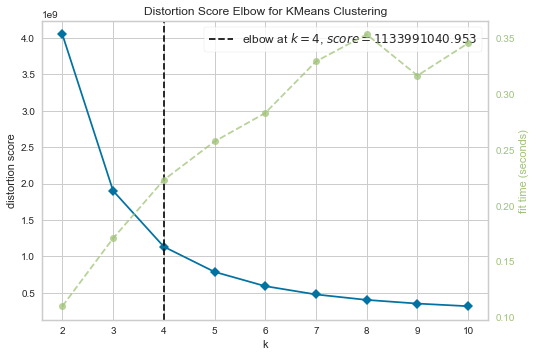

In [23]:
# Next step is applying K-means clustering to group by Recency from CustomerID
# But Before It is applyed the elbow method to get the number of clusters

# dataSet with CustomerID and Recency
X = df_recency[{'CustomerID', 'Recency'}]

# From 2 to 10 clusters
k=(1,10)

# Prints Elbow graph
X.print_elbow(k)

In [24]:
# Applys KMeans of 4 clusters in Recency column
X = df_customerDates[['Recency']]

df_customerDates['RecencyCluster'] = KMeans(4).fit(X).predict(X)
df_customerDates.head()

,CustomerID,NextPurchaseDay,Recency,RecencyCluster
0,12346.0,9999.0,225,3
1,12347.0,90.0,29,1
2,12348.0,173.0,148,3
3,12349.0,389.0,307,2
4,12350.0,9999.0,210,3


In [25]:
# Order by RecencyCluster
df_customerDates = df_customerDates.order_cluster('Recency', 'RecencyCluster', False)
df_customerDates.head()

,CustomerID,NextPurchaseDay,Recency,RecencyCluster
0,12346.0,9999.0,225,2
1,12348.0,173.0,148,2
2,12350.0,9999.0,210,2
3,12352.0,181.0,162,2
4,12353.0,9999.0,103,2


In [26]:
#print cluster characteristics
df_customerDates.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,750.0,520.509333,65.218473,418.0,465.0,517.0,571.5,638.0
1,1427.0,314.360196,41.129298,236.0,281.5,308.0,338.0,416.0
2,1101.0,155.620345,39.245629,97.0,118.0,153.0,187.0,234.0
3,2036.0,37.983301,27.739216,0.0,13.0,33.0,59.0,96.0


As shown the curster 3 covers most of the recent customers

## Frequency

In [27]:
# Gets the counts of purchase for each user
df_frequency = df_retails.groupby('CustomerID').InvoiceDate.count().reset_index()
df_frequency.columns = ['CustomerID', 'Frequency']

# Merges the main dataframe with the Recency dataframe
df_customerDates = df_customerDates.merge(df_frequency
                                        , on='CustomerID')

df_customerDates.head()                                       

,CustomerID,NextPurchaseDay,Recency,RecencyCluster,Frequency
0,12346.0,9999.0,225,2,48
1,12348.0,173.0,148,2,51
2,12350.0,9999.0,210,2,17
3,12352.0,181.0,162,2,113
4,12353.0,9999.0,103,2,24


In [28]:
# Checks the details of each cluster
df_customerDates.Frequency.describe()

count     5314.000000
mean       149.498495
std        378.177404
min          1.000000
25%         22.000000
50%         59.000000
75%        158.750000
max      13097.000000
Name: Frequency, dtype: float64

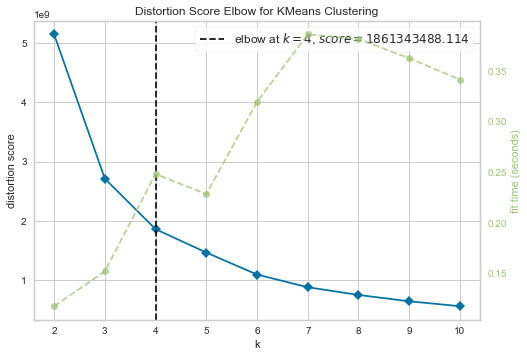

In [29]:
# Applies the elbow method to get the number of clusters

# dataSet with CustomerID and Recency
X = df_frequency[{'CustomerID', 'Frequency'}]

# From 2 to 10 clusters
k=(1,10)

# Prints Elbow graph
X.print_elbow(k)

In [30]:
# Applys KMeans of 4 clusters in Frequency column
X = df_customerDates[['Frequency']]

df_customerDates['FrequencyCluster'] = KMeans(4).fit(X).predict(X)

In [31]:
# Order by RecencyCluster
df_customerDates = df_customerDates.order_cluster('Frequency', 'FrequencyCluster', False)
df_customerDates.head()

,CustomerID,NextPurchaseDay,Recency,RecencyCluster,Frequency,FrequencyCluster
0,12346.0,9999.0,225,2,48,3
1,12348.0,173.0,148,2,51,3
2,12350.0,9999.0,210,2,17,3
3,12352.0,181.0,162,2,113,3
4,12353.0,9999.0,103,2,24,3


In [32]:
# Checks the details of each cluster
df_customerDates.groupby('FrequencyCluster')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,2.0,12355.000000,1049.346463,11613.0,11984.00,12355.0,12726.00,13097.0
1,14.0,3921.000000,1541.056680,2430.0,2829.50,3346.5,4570.25,7307.0
2,404.0,716.732673,318.764750,403.0,482.75,604.0,844.50,2134.0
3,4894.0,86.896404,91.175905,1.0,20.00,51.0,123.00,402.0


## Revenue

In [33]:
# Gets the Sum of the purchase value for each user
df_Revenue = df_retails.groupby('CustomerID').Revenue.sum().reset_index()
df_Revenue.columns = ['CustomerID', 'Revenue']

# Merges the main dataframe with the Recency dataframe
df_customerDates = df_customerDates.merge(df_Revenue[['CustomerID', 'Revenue']]
                                        , on='CustomerID')
df_customerDates.head()

,CustomerID,NextPurchaseDay,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue
0,12346.0,9999.0,225,2,48,3,-64.68
1,12348.0,173.0,148,2,51,3,2019.40
2,12350.0,9999.0,210,2,17,3,334.40
3,12352.0,181.0,162,2,113,3,1889.21
4,12353.0,9999.0,103,2,24,3,406.76


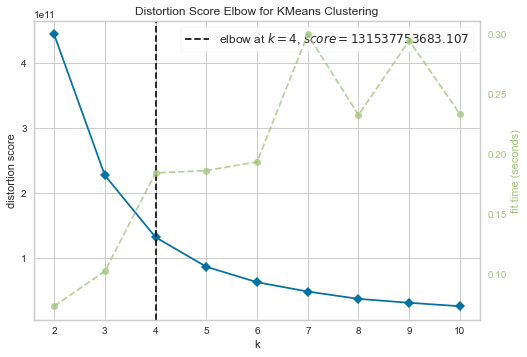

In [34]:
# Applies the elbow method to get the number of clusters

# dataSet with CustomerID and Recency
X = df_Revenue[{'CustomerID', 'Revenue'}]

# From 2 to 10 clusters
k=(1,10)

# Prints Elbow graph
X.print_elbow(k)

In [35]:
# Applys KMeans of 4 clusters in Revenue column
X = df_customerDates[['Revenue']]

df_customerDates['RevenueCluster'] = KMeans(4).fit(X).predict(X)
df_customerDates.head()

,CustomerID,NextPurchaseDay,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster
0,12346.0,9999.0,225,2,48,3,-64.68,0
1,12348.0,173.0,148,2,51,3,2019.40,0
2,12350.0,9999.0,210,2,17,3,334.40,0
3,12352.0,181.0,162,2,113,3,1889.21,0
4,12353.0,9999.0,103,2,24,3,406.76,0


In [36]:
# Orders the cluster numbers
df_customerDates = df_customerDates.order_cluster('Revenue', 'RevenueCluster', True)
df_customerDates.head()

,CustomerID,NextPurchaseDay,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster
0,12346.0,9999.0,225,2,48,3,-64.68,0
1,12348.0,173.0,148,2,51,3,2019.40,0
2,12350.0,9999.0,210,2,17,3,334.40,0
3,12352.0,181.0,162,2,113,3,1889.21,0
4,12353.0,9999.0,103,2,24,3,406.76,0


In [37]:
# Checks the details of each cluster
df_customerDates.groupby('RevenueCluster')['Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
0,5254.0,2094.826057,3318.857554,-25111.09,345.0625,930.5550,2355.6750,26278.86
1,50.0,50516.735860,22611.350789,26626.80,33190.5675,43522.8205,58026.3400,113513.07
2,8.0,198033.391250,62010.602305,136391.48,142827.5300,181355.7500,242746.6750,296564.69
3,2.0,560778.645000,52943.312094,523342.07,542060.3575,560778.6450,579496.9325,598215.22


## Overall Score

In [38]:
# Calculates the overall score 
df_customerDates['OverallScore'] = (df_customerDates['RecencyCluster']
                                  + df_customerDates['FrequencyCluster']
                                  + df_customerDates['RevenueCluster'])

# Get mean (Average) of Recency, Frequency, Revenue grouped by OverallScore
df_customerDates.groupby('OverallScore')['Recency', 'Frequency', 'Revenue'].mean()                                  

,Recency,Frequency,Revenue
OverallScore,,,
3,514.613281,39.929688,435.112398
4,308.918381,96.774348,1237.672534
5,126.275310,264.378004,3898.256192
6,40.359504,144.672373,3515.860632
7,12.450000,676.900000,109639.778000
8,26.000000,1068.000000,598215.220000


### The scoring above shows that the customer who has overall score 8 are the ones who last bought, those who buy with more frequency, and those who spend higher Over the others.

In [39]:
# Categories customers' into Segement based on their OverallScore

# Initially, giving 'Low-Value' for all 
df_customerDates['Segment'] = 'Low-Value'

# 'Mid-Value' for those with OverallScore higher than 4
df_customerDates.loc[df_customerDates['OverallScore'] > 4, 'Segment'] = 'Mid-Value'

# and 'High-Value' with those with Overall Score higher than 6
df_customerDates.loc[df_customerDates['OverallScore'] > 6, 'Segment'] = 'High-Value'

df_customerDates.head()

,CustomerID,NextPurchaseDay,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment
0,12346.0,9999.0,225,2,48,3,-64.68,0,5,Mid-Value
1,12348.0,173.0,148,2,51,3,2019.40,0,5,Mid-Value
2,12350.0,9999.0,210,2,17,3,334.40,0,5,Mid-Value
3,12352.0,181.0,162,2,113,3,1889.21,0,5,Mid-Value
4,12353.0,9999.0,103,2,24,3,406.76,0,5,Mid-Value


In [40]:
# Converts all categories as classes
df_customerClasses = pd.get_dummies(df_customerDates)
df_customerClasses.head()

,CustomerID,NextPurchaseDay,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment_High-Value,Segment_Low-Value,Segment_Mid-Value
0,12346.0,9999.0,225,2,48,3,-64.68,0,5,0,0,1
1,12348.0,173.0,148,2,51,3,2019.40,0,5,0,0,1
2,12350.0,9999.0,210,2,17,3,334.40,0,5,0,0,1
3,12352.0,181.0,162,2,113,3,1889.21,0,5,0,0,1
4,12353.0,9999.0,103,2,24,3,406.76,0,5,0,0,1


In [41]:
# Sets a column called 'Target' to 1. This colums will indicate whether a customer will purchase in the next 90 days

# Initially It is said all customers will buy in the next 90 days
df_customerClasses['Target'] = 1 

# Assignes 0 to those who do not suppose to buy in the next quarter
df_customerClasses.loc[df_customerClasses.NextPurchaseDay > 90, 'Target'] = 0

df_customerClasses.head()

,CustomerID,NextPurchaseDay,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment_High-Value,Segment_Low-Value,Segment_Mid-Value,Target
0,12346.0,9999.0,225,2,48,3,-64.68,0,5,0,0,1,0
1,12348.0,173.0,148,2,51,3,2019.40,0,5,0,0,1,0
2,12350.0,9999.0,210,2,17,3,334.40,0,5,0,0,1,0
3,12352.0,181.0,162,2,113,3,1889.21,0,5,0,0,1,0
4,12353.0,9999.0,103,2,24,3,406.76,0,5,0,0,1,0


In [42]:
#df_corrMatrix = f.GetCorrelationMatrix(df_customerClasses)
#print(df_corrMatrix)

In [43]:
#f.PlotHeatMap(df_corrMatrix)

In [44]:
# The columns NextPurchaseDay was used to estimate whether a customer will make a purchase, and will not be used in the next step, so It is droped from the dataframe
df_customerClasses = df_customerClasses.drop('NextPurchaseDay', axis=1)
df_customerClasses.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment_High-Value,Segment_Low-Value,Segment_Mid-Value,Target
0,12346.0,225,2,48,3,-64.68,0,5,0,0,1,0
1,12348.0,148,2,51,3,2019.40,0,5,0,0,1,0
2,12350.0,210,2,17,3,334.40,0,5,0,0,1,0
3,12352.0,162,2,113,3,1889.21,0,5,0,0,1,0
4,12353.0,103,2,24,3,406.76,0,5,0,0,1,0


# Machine Learning Models

In [46]:
X, y = df_customerClasses.drop('Target', axis=1), df_customerClasses.Target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=None, shuffle=True)

func.print_models_scores(X_train, y_train)

                        Model_name  Accuracy  F1_score  Recall  Precision
0                    XGBClassifier     88.45     79.15   80.67      78.38
1   MultiLayerPerceptronClassifier     88.33     78.75   80.40      77.91
2               NaiveBayesGaussian     88.26     78.34   79.85      77.40
3          NaiveBayesMultinomialNB     88.26     78.34   79.85      77.40
4       GradientBoostingClassifier     88.20     77.63   78.59      76.97
5               AdaBoostClassifier     87.83     76.57   77.56      75.89
6           RandomForestClassifier     87.34     75.10   76.05      74.48
7                   LGBMClassifier     87.31     71.18   73.17      69.62
8           DecisionTreeClassifier     86.66     73.15   74.23      72.42
9             KNeighborsClassifier     86.43     71.50   72.83      70.59
10              LogisticRegression     85.83     64.69   67.54      62.43
11   DummyClassifier_most_frequent     81.16     44.79   50.00      40.58
12                LinearRegression    

In [47]:
func.print_balanded_models_scores(X_train, y_train) 

0
<class 'imblearn.over_sampling._random_over_sampler.RandomOverSampler'>
1
2
3
4
5
6
7
8
9
0
<class 'imblearn.over_sampling._smote.filter.BorderlineSMOTE'>
1
2
3
4
5
6
7
8
9
0
<class 'imblearn.under_sampling._prototype_generation._cluster_centroids.ClusterCentroids'>
1
2
3
4
5
6
7
8
9
0
<class 'imblearn.under_sampling._prototype_selection._one_sided_selection.OneSidedSelection'>
1
2
3
4
5
6
7
8
9
0
<class 'imblearn.over_sampling._adasyn.ADASYN'>
1
2
3
4
5
6
7
8
9
0
<class 'imblearn.over_sampling._smote.base.SMOTE'>
1
2
3
4
5
6
7
8
9
0
<class 'imblearn.combine._smote_enn.SMOTEENN'>
1
2
3
4
5
6
7
8
9
0
<class 'imblearn.combine._smote_tomek.SMOTETomek'>
1
2
3
4
5
6
7
8
9
  Balancing_Model_name                        Shape          Model_name  \
0    OneSidedSelection  Counter({0: 4029, 1: 1006})       XGBClassifier   
1      BorderlineSMOTE  Counter({0: 4308, 1: 4308})       XGBClassifier   
2               ADASYN  Counter({0: 4308, 1: 4210})       XGBClassifier   
3                SMOTE